### Проект курса: Рекомендательная система

#### Постановка задачи
- Цель: Повысить прибыль от дополнительных продаж в интернет-магазине на 20%.
- Задача: Построить рекомендательную систему на основе предоставленных данных.
- Метрика: Precision@3 (какую долю из того, что мы порекомендовали, купил пользователь)

#### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import annoy
import pickle
import lightfm
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.sparse import coo_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score

from gensim.models import FastText
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime

#### Загрузка датасетов

In [2]:
events = pd.read_csv('data/events.csv')
category_tree = pd.read_csv('data/category_tree.csv')
item_properties_part1 = pd.read_csv('data/item_properties_part1.csv')
item_properties_part2 = pd.read_csv('data/item_properties_part2.csv')

In [3]:
# Объединяем item_properties
item_properties = pd.concat([item_properties_part1, item_properties_part2])

#### Описание данных. EDA

##### events — датасет с событиями.  
timestamp — время события  
visitorid — идентификатор пользователя  
event — тип события  
itemid — идентификатор объекта  
transactionid — идентификатор транзакции, если она проходила

In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [5]:
events.sample(5)

,timestamp,visitorid,event,itemid,transactionid
846229,1439605824413,682559,view,204494,NaN
1825285,1432145187731,211640,view,330785,NaN
1640743,1431469468333,65471,view,234670,NaN
1845014,1432230813424,1215108,view,118656,NaN
1341099,1441945352457,1115940,view,218794,NaN


In [6]:
# Проверим events на дубликаты
events.duplicated().sum()

460

In [7]:
# events содержит дубликаты, почистим
events.drop_duplicates(inplace=True)

In [8]:
# Для удобства конвертируем timestamp в datetime
events['datetime'] = pd.to_datetime(events.timestamp, unit='ms')

In [9]:
print(f"Данные за период: {min(events['datetime'])} - {max(events['datetime'])}")

Данные за период: 2015-05-03 03:00:04.384000 - 2015-09-18 02:59:47.788000


<AxesSubplot:xlabel='datetime'>

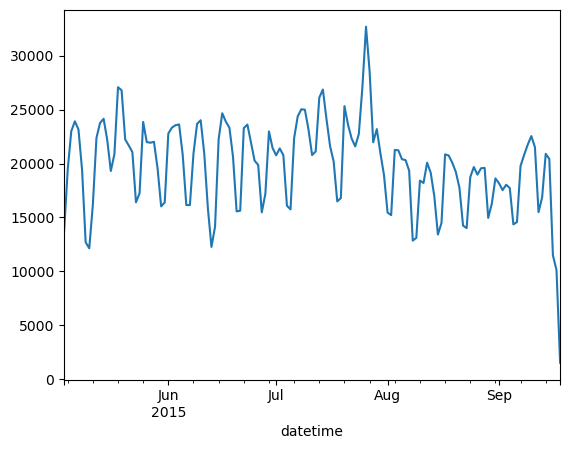

In [10]:
# Визуализируем активность по дате
event_date = events.resample('D', on='datetime').count()
event_date['event'].plot()

In [11]:
# visitorid
print(f'Уникальных посетителей: {len(events.visitorid.unique())}')

Уникальных посетителей: 1407580


In [12]:
# event
events.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

Датасет содержит три типа события: просмотр, добавление товара в корзину и покупка (транзакция)

<AxesSubplot:xlabel='event', ylabel='count'>

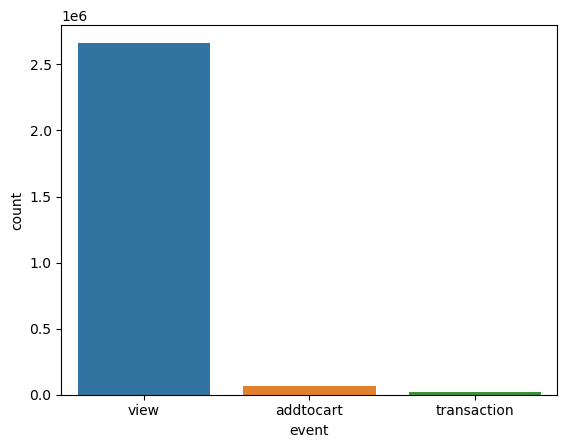

In [13]:
# Посмотрим на соотношение
sns.countplot(data=events, x='event')

Датасет не сбалансирован. Категория view значительно преобладает над остальными

In [14]:
# Purchase rate
len(events[events.event == 'transaction']) / len(events[events.event == 'view']) * 100

0.842911503488078

Purchase rate менее одного процента

In [15]:
# Топ 10 активных посетителей
events.visitorid.value_counts().head(10)

1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
Name: visitorid, dtype: int64

In [16]:
# Топ 10 покупателей
df_top_tran = events[events.transactionid>=0][['visitorid', 'transactionid']].groupby('visitorid').agg(len).astype('uint16').sort_values(by='transactionid', ascending=False).head(10)
df_top_tran.columns=['number of transactions']
df_top_tran

,number of transactions
visitorid,
1150086,559
152963,349
530559,286
684514,189
861299,188
76757,185
138131,173
890980,145
1297062,136


In [17]:
# Уникальных товаров в событиях
print(f'Уникальных товаров: {len(events.itemid.unique())}')

Уникальных товаров: 235061


##### category_tree — файл с деревом категорий
categoryid — идентификатор категорий  
parentid — идентификатор родительской категории

In [18]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [19]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


У ряда категорий отсутсвует родительская (пропущенные значения) -> вершина

In [20]:
# Проверим category_tree на дубликаты
category_tree.duplicated().sum()

0

In [21]:
print('categoryid', len(category_tree.categoryid.unique()))
print('parentid', len(category_tree.parentid.unique()))

categoryid 1669
parentid 363


##### item_properties — файл со свойствами товаров
timestamp — момент записи значения свойства  
item_id — идентификатор объекта  
property — свойства, захешированы  
value — значение свойства

In [22]:
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [23]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


Значения параметров закодированы

In [24]:
# Проверим на дудликаты
item_properties.duplicated().sum()

0

In [25]:
print(f'Количетсво товаров в справочнике: {len(item_properties.itemid.unique())}')

Количетсво товаров в справочнике: 417053


#### Понижение размерности

In [26]:
# Установим минимальное значение
min_count = 50

# Посчитаем действия посетителей
visitors_events = events[['visitorid', 'event']].groupby(['visitorid']).count().reset_index()
# Отбросим неактивных (менее min_count действий)
visitors = visitors_events[visitors_events.event >= min_count].visitorid.to_list()
print(len(visitors))

# Посчитаем популярные товары
popular_items = events.groupby(['itemid']).count().reset_index()[['itemid','event']].sort_values('event', ascending=False)
# Отбросим менее востребованные (менее min_count действий)
items = popular_items[popular_items.event >= min_count].itemid.to_list()
print(len(items))

1265
11165


In [27]:
events = events[events.visitorid.isin(visitors) & events.itemid.isin(items)]

Понижение размерности заметно улучшает результат

#### Разаделение данных на обучающую и валидационную выборку

Разделим данные по дате 01.07.2015

In [28]:
events_train = events[events.datetime <= '2015-07-01']
events_valid = events[events.datetime > '2015-07-01']

#### Статистический анализ данных

In [29]:
# Отфильтруем тестовую выборку
events_valid = events_valid[(events_valid['visitorid'].isin(events_train['visitorid'])) 
                          & (events_valid['itemid'].isin(events_train['itemid']))]

In [30]:
print(events_train.shape)
print(events_valid.shape)

(57160, 6)
(21007, 6)


In [31]:
# События представим в виде отдельных признаков
def dummy_events(df):
    return pd.get_dummies(data=df, columns=['event'])

In [32]:
events_train_d = dummy_events(events_train)
events_valid_d = dummy_events(events_valid)

Проведём оценку равности долей (Z-test)

In [33]:
events_train_d.head()

,timestamp,visitorid,itemid,transactionid,datetime,event_addtocart,event_transaction,event_view
110,1433221740333,712443,346655,NaN,2015-06-02 05:09:00.333,0,0,1
137,1433221523348,1118731,350689,NaN,2015-06-02 05:05:23.348,0,0,1
194,1433193990704,85734,331725,NaN,2015-06-01 21:26:30.704,0,0,1
196,1433193535886,820159,369447,NaN,2015-06-01 21:18:55.886,0,0,1
211,1433194177067,1185234,154912,NaN,2015-06-01 21:29:37.067,0,0,1


In [34]:
def get_ztest_metrics(df1, df2, column):
    """ Тест на равенство долей """
    count = [df1[column].sum(), df2[column].sum()]
    nobs = [len(df1[column]), len(df2[column])]
    stat, pval = proportions_ztest(count, nobs)
    print(f'p-value: {pval}')
    print(f'Тест на равенство долей: {pval > alpha}')
    return pval

In [35]:
alpha = 0.05

for column in ['event_addtocart','event_transaction','event_view']:
    print(column)
    pvalue = get_ztest_metrics(events_train_d, events_valid_d, column)
    print()

event_addtocart
p-value: 0.2542956885740091
Тест на равенство долей: True

event_transaction
p-value: 0.7593252070517664
Тест на равенство долей: True

event_view
p-value: 0.26205928745208973
Тест на равенство долей: True



Получили положительный результат по всем признакам

#### Генерация признаков

Сформируем рейтинг исходя из действий посетителей

In [36]:
# Опишем dict
event_to_rating = {
    'view': 1, 
    'addtocart': 2, 
    'transaction': 3
}

In [37]:
def get_ratings(df):
    df['action'] = df.event.map(event_to_rating)
    df_with_ratings = df[['datetime', 'visitorid', 'itemid', 'action']].groupby(['visitorid', 'itemid']).agg(max).reset_index()
    df_with_ratings.columns=['visitorid', 'itemid', 'datetime', 'rating']
    return df_with_ratings

In [38]:
events_train_ratings = get_ratings(events_train)
events_valid_ratings = get_ratings(events_valid)

In [39]:
events_train_ratings.sample(5)

,visitorid,itemid,datetime,rating
10987,530033,247376,2015-06-04 20:18:15.634,1
25542,1352334,75152,2015-05-19 04:05:25.235,1
6374,286616,372169,2015-06-06 23:14:37.811,1
15080,765630,16344,2015-06-23 18:01:23.429,1
3449,138604,387318,2015-06-15 22:37:49.903,1


In [40]:
events_train_ratings.rating.value_counts()

1    22861
3     2003
2     1341
Name: rating, dtype: int64

In [41]:
### Future 

Признаки на основе даты

In [42]:
def get_feature_datetime(df):
    """ Добавляет признаки на основе даты """
    df['month'] = df.datetime.map(lambda x: x.month)
    df['week'] = df.datetime.map(lambda x: x.week)
    df['day_of_week'] = df.datetime.map(lambda x: x.weekday())
    df['day'] = df.datetime.map(lambda x: x.day)
    df['hour'] = df.datetime.map(lambda x: x.hour)
    return df

In [43]:
events = get_feature_datetime(events.copy())

In [44]:
# events['grouped_param'] = events.timestamp.apply(str) + '_' + events.visitorid.apply(str) + '_' + events.itemid.apply(str)
# events.head()

##### Item-based признаки

In [45]:
# Добавим признаки categoryid, parentid
need_prop = ['categoryid']
item_cat = item_properties[item_properties.property.isin(need_prop)][['itemid', 'property', 'value']]
# Удалим дубликаты
item_cat.drop_duplicates(inplace=True)
item_cat.value = item_cat.value.astype('int64')
# Мержим
item_cat = item_cat.merge(category_tree, how='left', left_on='value', right_on='categoryid')

item_cat.head()

,itemid,property,value,categoryid,parentid
0,460429,categoryid,1338,1338.0,1278.0
1,281245,categoryid,1277,1277.0,312.0
2,35575,categoryid,1059,1059.0,1696.0
3,8313,categoryid,1147,1147.0,1027.0
4,55102,categoryid,47,47.0,381.0


In [46]:
# Мержим
events = events.merge(item_cat[['itemid', 'categoryid', 'parentid']], how='left', on='itemid')
events.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,month,week,day_of_week,day,hour,categoryid,parentid
0,1433221740333,712443,view,346655,NaN,2015-06-02 05:09:00.333,6,23,1,2,5,1220.0,125.0
1,1433221523348,1118731,view,350689,NaN,2015-06-02 05:05:23.348,6,23,1,2,5,1634.0,143.0
2,1433193990704,85734,view,331725,NaN,2015-06-01 21:26:30.704,6,23,0,1,21,1584.0,1562.0
3,1433193535886,820159,view,369447,NaN,2015-06-01 21:18:55.886,6,23,0,1,21,48.0,500.0
4,1433194177067,1185234,view,154912,NaN,2015-06-01 21:29:37.067,6,23,0,1,21,1503.0,580.0


In [47]:
# Выполним encoding
events = pd.get_dummies(data=events, columns=['event'])

In [48]:
# Популярность товара
item_pop = events[['visitorid', 'itemid', 'event_addtocart', 'event_transaction', 'event_view']].groupby('itemid').agg(
    {'visitorid': 'count',
    'event_addtocart': 'sum',
    'event_transaction': 'sum',
    'event_view': 'sum'
    }).reset_index()
item_pop.columns = ['itemid', 'visitors_count', 'event_addtocart_count', 'event_transaction_count', 'event_view_count']
item_pop.sort_values(by='event_transaction_count', ascending=False).head()

,itemid,visitors_count,event_addtocart_count,event_transaction_count,event_view_count
2235,119736,675,27,93,555.0
3990,213834,141,4,28,109.0
6097,320130,336,36,28,272.0
832,46156,176,32,20,124.0
8754,461686,280,27,15,238.0


In [49]:
# Purchase rate
item_pop['purchase_rate'] = item_pop.event_transaction_count/item_pop.event_view_count
# Есть несколько транзакций без просмотра
item_pop.purchase_rate = item_pop.purchase_rate.replace(np.inf, np.nan).fillna(1)

item_pop.sort_values(by='purchase_rate', ascending=False).head(10)

,itemid,visitors_count,event_addtocart_count,event_transaction_count,event_view_count,purchase_rate
3612,193908,3,0,2,1.0,2.0
821,45330,3,1,1,1.0,1.0
2498,134322,3,1,1,1.0,1.0
8340,440129,3,1,1,1.0,1.0
7323,384605,3,1,1,1.0,1.0
260,15212,6,2,2,2.0,1.0
3987,213785,7,3,2,2.0,1.0
6365,335913,6,2,2,2.0,1.0
7168,376944,3,1,1,1.0,1.0
1548,83995,3,1,1,1.0,1.0


Можно выделить наиболее популярные категории

In [50]:
# Популярные категории
category_pop = events[['event_transaction', 'categoryid']].groupby('categoryid').agg(sum).sort_values(by='event_transaction', ascending=False)

# Будем считать, что наиболее популярные категории >= 75% квантиля (по транзакциям)
quantile_75 = np.quantile(category_pop.event_transaction, 0.75, axis=0)

category_pop['category_pop'] = (category_pop.event_transaction > quantile_75).astype('int8')
category_pop.reset_index(inplace=True)
# Мержим
events = events.merge(category_pop[['categoryid', 'category_pop']], how='left', on='categoryid')
events.category_pop = events.category_pop.fillna(0)
events.head()


,timestamp,visitorid,itemid,transactionid,datetime,month,week,day_of_week,day,hour,categoryid,parentid,event_addtocart,event_transaction,event_view,category_pop
0,1433221740333,712443,346655,NaN,2015-06-02 05:09:00.333,6,23,1,2,5,1220.0,125.0,0,0,1,1.0
1,1433221523348,1118731,350689,NaN,2015-06-02 05:05:23.348,6,23,1,2,5,1634.0,143.0,0,0,1,0.0
2,1433193990704,85734,331725,NaN,2015-06-01 21:26:30.704,6,23,0,1,21,1584.0,1562.0,0,0,1,1.0
3,1433193535886,820159,369447,NaN,2015-06-01 21:18:55.886,6,23,0,1,21,48.0,500.0,0,0,1,1.0
4,1433194177067,1185234,154912,NaN,2015-06-01 21:29:37.067,6,23,0,1,21,1503.0,580.0,0,0,1,1.0


##### User-based признаки

In [51]:
# Опеределим поведение пользователей
users_data = events.groupby('visitorid').agg({
    'itemid': 'count',
    'parentid': 'nunique',
    'timestamp': ['min', 'max']
}).reset_index()
users_data.head()

visitorid itemid parentid      timestamp               
             count  nunique            min            max
0      1722     80        1  1430847780195  1434035279146
1      1879     55       17  1430929545966  1440784311705
2      2194     57       11  1440215427937  1441799043411
3      6699     87       19  1431034227547  1431054066009
4      6958     70        3  1435525675076  1436736821356

In [52]:
users_data.columns = ['visitorid', 'item_count', 'category_count', 'first_action', 'last_action']
users_data['alltime'] = users_data['last_action'] - users_data['first_action']
users_data['time_on_action'] = users_data['alltime'] / (users_data['item_count'])
users_data.head()

,visitorid,item_count,category_count,first_action,last_action,alltime,time_on_action
0,1722,80,1,1430847780195,1434035279146,3187498951,3.984374e+07
1,1879,55,17,1430929545966,1440784311705,9854765739,1.791776e+08
2,2194,57,11,1440215427937,1441799043411,1583615474,2.778273e+07
3,6699,87,19,1431034227547,1431054066009,19838462,2.280283e+05
4,6958,70,3,1435525675076,1436736821356,1211146280,1.730209e+07


In [53]:
### END of Feature generating #####

#### Проведение экспериментов

##### SVD

In [54]:
from surprise import KNNWithMeans, KNNBasic, SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate, KFold

In [55]:
def prepare_dataset(df):
    """ Подготовка датасета для surprise """
    dataset = df[['visitorid', 'itemid', 'rating']].rename({
    "visitorid": "uid",
    "itemid": "iid"})
    reader = Reader(rating_scale=(1, 3))
    return Dataset.load_from_df(dataset, reader)

In [56]:
def precision_recall_at_k(predictions, k=3, threshold=2):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [57]:
def precision_recall_at_k_mean(predictions):
    precisions, recalls = precision_recall_at_k(predictions, k=3, threshold=2)

    # Precision and recall can then be averaged over all users
    print(round(sum(prec for prec in precisions.values()) / len(precisions), 5))
    print(round(sum(rec for rec in recalls.values()) / len(recalls), 5))

In [58]:
# Подготовим данные
trainset, testset = prepare_dataset(events_train_ratings), prepare_dataset(events_valid_ratings)

In [59]:
# Для валидации сформируем список
testset = [testset.df.loc[i].to_list() for i in range(len(testset.df))]

In [60]:
model = SVD()

Ради эксперимента сделаем два варианта разделения на обучающую и валидационные выборки:
- Кросс-валидация
- Разделение по дате 01.07.2015

In [61]:
# 1) cross-validate
cross_validate(model, trainset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5404  0.5305  0.5388  0.5516  0.5459  0.5414  0.0071  
MAE (testset)     0.3258  0.3220  0.3253  0.3331  0.3302  0.3273  0.0039  
Fit time          1.23    1.27    1.41    1.29    1.19    1.28    0.07    
Test time         0.03    0.03    0.04    0.03    0.03    0.03    0.00    


{'test_rmse': array([0.54039827, 0.53050584, 0.53876623, 0.55157416, 0.54591589]),
 'test_mae': array([0.32582031, 0.32203067, 0.32532786, 0.33312334, 0.33023167]),
 'fit_time': (1.2333157062530518,
  1.2689208984375,
  1.4051766395568848,
  1.291294813156128,
  1.1949596405029297),
 'test_time': (0.03487873077392578,
  0.03142118453979492,
  0.0377049446105957,
  0.030344724655151367,
  0.03468918800354004)}

In [62]:
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.5377


0.5376918179227063

In [63]:
precision_recall_at_k_mean(predictions)

0.01245
0.0036


Результат: precision@3 = 1,0%

In [64]:
# 2) Basic fit
model = SVD()
trainset = trainset.build_full_trainset()
model.fit(trainset)

In [65]:
predictions = model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.5401


0.5401366705768567

In [66]:
precision_recall_at_k_mean(predictions)

0.00952
0.00331


Результат: precision@3 = 1,1%

**Вывод:** разделение данных для обучения и валидации относительно даты даёт немного лучше результат и составляет precision@3 = 1,1%

##### Коллаборативная фильтрация

Реализация классической коллаборативной фильтрации находится в классе KNNWithMeans.  
Для определения гиперпараметров используем GridSearchCV из пакета surprise

##### Подбор гиперпараметров

In [67]:
from surprise.model_selection.search import GridSearchCV

In [68]:
param_grid = {'k': [k for k in range(10,60,10)],
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [True, False]}
              }

In [69]:
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=3)

In [70]:
gs.fit(prepare_dataset(pd.concat([events_train_ratings,events_valid_ratings])))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity ma

In [71]:
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.5997918584582783
{'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}}


GridSearchCV определил параметры  {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}} как наиболее оптимальные.

In [72]:
# Подготовим данные
trainset, testset = prepare_dataset(events_train_ratings), prepare_dataset(events_valid_ratings)
trainset = trainset.build_full_trainset()
# Для валидации сформируем список
testset = [testset.df.loc[i].to_list() for i in range(len(testset.df))]

In [73]:
# 1)  В качестве гиперпараметров будем использовать пареметры от GridSearchCV (best_params)
sim_options = {'name': 'cosine', 'user_based': True}
# Обучаем модель
model_knn = KNNWithMeans(k=40, sim_options=sim_options)
model_knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [74]:
# Выполняем прогноз
predictions = model_knn.test(testset)

Считаем RMSE:

In [75]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.6001


0.6001159067004287

In [76]:
precision_recall_at_k_mean(predictions)

0.03333
0.01824


Результат: precision@3 = 3,3%

In [77]:
# 2. Эксперимент. В качестве гиперпараметров будем использовать коэффициент корреляции Пирсона
sim_options = {'name': 'pearson_baseline', 'user_based': False}
# Обучаем модель
model_knn = KNNWithMeans(k=50, sim_options=sim_options)
predictions = model_knn.fit(trainset).test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [78]:
accuracy.rmse(predictions, verbose=True)

RMSE: 0.6360


0.6360011150392296

In [79]:
precision_recall_at_k_mean(predictions)

0.06227
0.03281


**Вывод:** Результат: precision@3 = 6,2%

RMSE хуже подоброннаго GridSearchCV, но с этими параметрами наша метрика precision@3 лучше.

##### Экспорт данных

In [80]:
# Экспорт данных для сервиса
# testset (для отображения метрик)
with open('export/testset.pickle', 'wb') as file:
    pickle.dump(testset, file)
# Модель KNNWithMeans (для прогноза)
with open('export/model_knn.pickle', 'wb') as file:
    pickle.dump(model_knn, file)

##### Подбор рекомендаций

In [81]:
# Рассмотрим методы, которые нам понадобятся
# Отображение uid (visitorid)
model_knn.trainset.to_inner_uid(1403769)

832

In [82]:
# Отображение iid (itemid)
model_knn.trainset.to_inner_iid(248605)

4871

In [83]:
# Проверка на содержание item в модели (для анализа некорректного ввода)
model_knn.trainset.knows_item(248605)

False

In [84]:
# Формируем список товаров известных модели
items_all = events_train_ratings.itemid.unique().tolist()

In [85]:
def get_predict(model, uid, iid):
    """ Возвращает прогноз по заданным признакам """
    return model.predict(uid=uid, iid=iid)

In [86]:
# Получить прогоз с параметрами uid=6958, iid=248605
get_predict(model_knn, 6958, 248605)

Prediction(uid=6958, iid=248605, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False})

est=1

In [87]:
# Выполнить прогноз для uid=6958 по всем товарам
predict_1404178 = [get_predict(model_knn, 6958, x) for x in items_all]

In [129]:
predict_1404178[:10]

[Prediction(uid=6958, iid=381314, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=10572, r_ui=None, est=1.3333333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=29167, r_ui=None, est=1.25, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=29863, r_ui=None, est=1.125, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=42002, r_ui=None, est=1.391304347826087, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=114250, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=126929, r_ui=None, est=1.4285714285714286, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=251394, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958, iid=297765, r_ui=None, est=1, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=6958

In [89]:
def get_k_similar_items(iid, k=3):
    """ Получить k рекомендаций похожих товаров """
    inner_iid = model_knn.trainset.to_inner_iid(iid)
    model_knn.get_neighbors(inner_iid, 3)
    return [model_knn.trainset.to_raw_iid(x) for x in model_knn.get_neighbors(inner_iid, k)]

In [90]:
# Получить k похожих товаров
pred_iid = 1879
get_k_similar_items(pred_iid)

[381314, 10572, 29167]

In [91]:
pred_uid = 1403769
# Показать действия посетителя pred_uid
events_valid_ratings[(events_valid_ratings.visitorid == pred_uid) & (events_valid_ratings.rating > 1)]

,visitorid,itemid,datetime,rating
9681,1403769,73123,2015-08-11 17:31:52.970,3
9704,1403769,248605,2015-08-04 01:02:55.495,2
9711,1403769,312728,2015-09-11 21:15:35.187,3
9724,1403769,409804,2015-07-15 00:37:46.159,3


In [92]:
# Выполнить прогнозирование для pred_uid по всем товарам и показать top 3
pd.DataFrame([model_knn.predict(pred_uid, iid) for iid in items_all]).sort_values('est', ascending=False)[:3] #.iid.to_list()

,uid,iid,r_ui,est,details
1169,1403769,68708,None,3.0,"{'actual_k': 0, 'was_impossible': False}"
2155,1403769,388308,None,3.0,"{'actual_k': 0, 'was_impossible': False}"
3498,1403769,230605,None,3.0,"{'actual_k': 0, 'was_impossible': False}"


##### Обработка ошибок

In [93]:
# Получим raw_iid/raw_uid
items_all = [model_knn.trainset.to_raw_iid(x) for x in model_knn.trainset.all_items()]
user_all = [model_knn.trainset.to_raw_uid(x) for x in model_knn.trainset.all_users()]

In [94]:
# Обработка ошибки неивзестного посетителя
user_id = 1403769
if user_id not in user_all:
    print('Неизвестный посетитель')

In [95]:
# Обработка ошибки неивзестного товара
items_id = 5462121
if items_id not in items_all:
    print('Неизвестный товар')

Неизвестный товар


##### ALS

In [96]:
import scipy

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

In [97]:
# Задаем наименования колонкам
events_train_ratings.columns = ['user_id', 'item_id', 'datetime', 'rating']
events_valid_ratings.columns = ['user_id', 'item_id', 'datetime', 'rating']

In [98]:
events_train_ratings['score'] = (events_train_ratings['rating'] > 1).apply(int)
events_valid_ratings['score'] = (events_valid_ratings['rating'] > 1).apply(int)

In [99]:
# Выполняем LabelEncoder
id_cols=['user_id','item_id']

trans_cat_train = dict()
trans_cat_test = dict()

for k in id_cols:
    cat_enc = preprocessing.LabelEncoder()
    trans_cat_train[k] = cat_enc.fit_transform(events_train_ratings[k].values)
    trans_cat_test[k] = cat_enc.transform(events_valid_ratings[k].values)

In [100]:
trans_cat_train

{'user_id': array([  0,   1,   1, ..., 833, 833, 833], dtype=int64),
 'item_id': array([5923,  151,  424, ..., 6226, 6815, 6898], dtype=int64)}

In [101]:
ratings = dict()

ratings['train'] = events_train_ratings.rating.values
ratings['test'] = events_valid_ratings.rating.values

In [102]:
n_users=len(np.unique(trans_cat_train[id_cols[0]]))
n_items=len(np.unique(trans_cat_train[id_cols[1]]))

In [103]:
print(n_users)
print(n_items)

834
7238


In [104]:
# Формируем разреженные матрицы
rate_matrix = dict()

In [105]:
rate_matrix['train'] = coo_matrix((ratings['train'], 
                                   (trans_cat_train[id_cols[0]], 
                                    trans_cat_train[id_cols[1]])), 
                                    shape=(n_users,n_items))

In [106]:
rate_matrix['test'] = coo_matrix((ratings['test'], 
                                   (trans_cat_test[id_cols[0]], 
                                    trans_cat_test[id_cols[1]])), 
                                    shape=(n_users,n_items))

In [107]:
rate_matrix['train']

<834x7238 sparse matrix of type '<class 'numpy.int64'>'
	with 26205 stored elements in COOrdinate format>

In [108]:
# Обучаем модель ALS
model_als = AlternatingLeastSquares(factors=10, random_state=42)
model_als.fit(rate_matrix['train'])

  0%|          | 0/15 [00:00<?, ?it/s]

In [109]:
# Смотрим метрику Precision@3
map_at3 = mean_average_precision_at_k(model_als, rate_matrix['train'], rate_matrix['test'], K=3)
print('Mean Average Precision at 3: {:.4f}'.format(map_at3))

  0%|          | 0/455 [00:00<?, ?it/s]

Mean Average Precision at 3: 0.0134


**Вывод**: Результат модели ALS, Precision@3 = 1,3%

In [110]:
# Экспорт данных
# model_als.save('model_als.dump')
# with open('model_als.pickle', 'wb') as file:
#    pickle.dump(model_als, file)
# with open('rate_matrix.pickle', 'wb') as file:
#     pickle.dump(rate_matrix, file)
# with open('trans_cat_train.pickle', 'wb') as file:
#     pickle.dump(trans_cat_train, file)

##### LightFM

In [111]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k

In [112]:
# Обучаем модель LightFM
model_lfm = LightFM(no_components=10, loss='warp', random_state=42)
model_lfm.fit(rate_matrix['train'], epochs=100)

In [113]:
auc_score(model_lfm, rate_matrix['test'], num_threads=10).mean()

0.7137851

In [114]:
def model_evaluate(model):
    ''' Оценка модели, Precision at 3 '''
    item_ids = np.arange(0, rate_matrix['train'].shape[1])
    list_pred = model.predict(user_id, item_ids)
    recomendations_ids = np.argsort(-list_pred)[:3]
    recomendations = unique_items[recomendations_ids]
    print('Recomendations for user {}: {}'.format(user_id, recomendations))
    
    map_at3 = precision_at_k(model, rate_matrix['test'], k=3).mean()
    print('Mean Average Precision at 3: {:.3f}'.format(map_at3))

In [115]:
unique_items = np.array(trans_cat_train[id_cols[1]])
user_id = 14

model_evaluate(model_lfm)

Recomendations for user 14: [5526 2025  545]
Mean Average Precision at 3: 0.046


**Вывод:** Результат модели LightFM, Precision@3 = 4,6%

In [116]:
# Экспорт данных
# with open('model_lfm.pickle', 'wb') as file:
#    pickle.dump(model_lfm, file)

In [117]:
trans_cat_train[id_cols[0]]

array([  0,   1,   1, ..., 833, 833, 833], dtype=int64)

In [118]:
# Показать 3 рекомендации товаров для user_id
item_ids = np.arange(0, rate_matrix['train'].shape[1])
list_pred = model_lfm.predict(user_id, item_ids)

print(np.argsort(-list_pred)[:3])
print(np.argsort(list_pred)[:3])

[ 486 1412  545]
[3475 2610 5907]


##### XGBoost

In [119]:
def get_label(df):
    if (df.event_transaction):
        return 2
    elif (df.event_addtocart):
        return 1
    else:
        return 0

In [120]:
events['y'] = events.apply(get_label, axis=1)

In [121]:
for column in ['categoryid', 'parentid']: 
    events[column] = events[column].fillna(0).astype('int64')

In [122]:
# Разобъём датасет на обучающую и валидацционную выборку
events_train = events[events.datetime <= '2015-07-01']
events_valid = events[events.datetime > '2015-07-01']

In [123]:
X_train = events_train[['visitorid','itemid','month','week','day_of_week','day','hour','categoryid','parentid','category_pop']]
y_train = events_train['y']
X_test = events_valid[['visitorid','itemid','month','week','day_of_week','day','hour','categoryid','parentid','category_pop']]
y_test = events_valid['y']

In [124]:
# Обучение модели
param = {
   'max_depth': 3,
   'eta': 0.3, 
   'objective': 'multi:softprob',
   'num_class': 3}
num_round = 20

model = xgb.XGBClassifier(param)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [125]:
predictions = model.predict(X_test)

In [126]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.8848839071257005

##### Вывод  
Лучший результат метрики Precision@3 показали:
- метод коллаборативной фильтрации с результатом Precision@3 = 6,2%
- LightFM, с результатом Precision@3 = 4,6%  

Подготовим сервис на основе модели KNNWithMeans от surprise

#### Подготовка сервиса

##### Создание docker-образа

Структура каталогов:
```
.
├── Dockerfile
├── export
│   ├── model_knn.pickle
│   └── testset.pickle
├── requirements.txt
└── webservice
    ├── app.py
    ├── data
    └── ml_model_knn.py
```

Подготовим Dockerfile  
В производственной среде не стоит запускать чистый flask. Запустим сервис через wsgi - waitress-serve:  
```FROM python:3.10.13-slim-bullseye

RUN apt update &&  apt install -y gcc

COPY requirements.txt /

RUN pip3 install --upgrade pip

RUN pip3 install -r /requirements.txt

EXPOSE 8080

WORKDIR /opt/app

COPY webservice .
COPY export ./data

ENTRYPOINT ["waitress-serve", "--host", "0.0.0.0", "app:app"]
```

Команда для создания образа     
`docker build -t belichenkoas/recommend:latest -f Dockerfile .`

Опубликовать docker-образ  
*Предварительно следует авторизоваться `docker login`*  
`docker push belichenkoas/recommend:latest`

Чтобы скачать **готовый образ** с dockerhub нужно выполнить команду:  
`docker pull belichenkoas/recommend:latest`

##### Запуск сервиса  
`docker run -d --name recommendation_system -p 8080:8080 belichenkoas/recommend:latest`

##### Описание API

Сервис рекомендательной системы.  
Возвращает рекомендации Топ 3 товаров для посетителя

***Точка входа:***  
http://localhost:8080

Спецификация json.  
В ответе содержится статус и результат исполнения запроса.  
"Status" может принимать значение "Successful" или "Error".


***Проверка подключения***  
`Описание:` Позволяет проверить связь с сервисом
---
`Method:` /api/healthz  
`Request Method:` GET  
`Request URL:` http://localhost:8080/api/healthz  
---
Пример:
```
curl --location --request GET 'http://localhost:8080/api/healthz' \
--header 'Content-Type: application/json'
```

В случае успешного ответа, вернётся следующее значение:
```
{
  "Result": "Ok",
  "Status": "Success"
}
```

***Получение списка рекомендаций***  
`Описание:` метод возвращает топ 3 рекомендации товара для заданного посетителя
---
`Method:` /api/get_recommendations/<user_id\>  
`Request Method:` GET  
`Request URL:` http://localhost:8080/api/get_recommendations/<user_id\>

Где <user_id\> - Id посетителя

---
Пример:
```
curl --location --request GET 'http://localhost:8080/api/get_recommendations/1311615' \
--header 'Content-Type: application/json'
```

В случае успешного ответа, вернётся следующее значение:
```
{
  "Result": {
    "Recommendations for user 1311615": [
      381314,
      98893,
      262169
    ]
  },
  "Status": "Success"
}
```

В случае некорректного ввода данных, сервис предложит варианты:
```
{
  "Result": "Unknown visitor. Hint: you can use these ids (random 5): [121914, 1142436, 321381, 623304, 167489]",
  "Status": "Error"
}
```

***Получение метрики***  
`Описание:` метод возвращает значение метрик для активной модели
---
`Method:` /api/get_metrics  
`Request Method:` GET  
`Request URL:` http://localhost:8080/api/get_metrics  
---
Пример:
```
curl --location --request GET 'http://localhost:8080/api/get_metrics' \
--header 'Content-Type: application/json'
```

В случае успешного ответа, вернётся следующее значение:
```
{
  "Result": {
    "Precision at 3": 0.06227,
    "Recall at 3": 0.03281,
    "Rmse": 0.6361
  },
  "Status": "Success"
}
```